<a href="https://colab.research.google.com/github/tensorflow-project/FineTuning/blob/main/Experiments/CosineSimilarity2Concepts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
get_ipython().system('pip install -q git+https://github.com/keras-team/keras-cv.git')
get_ipython().system('pip install -q tensorflow==2.11.0')
get_ipython().system('pip install pyyaml h5py')


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 101.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 99.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!git clone https://github.com/tensorflow-project/FineTuning

Cloning into 'FineTuning'...
remote: Enumerating objects: 2062, done.
remote: Counting objects: 100% (1025/1025), done.
remote: Compressing objects: 100% (417/417), done.
remote: Total 2062 (delta 774), reused 819 (delta 603), pack-reused 1037
Receiving objects: 100% (2062/2062), 190.90 MiB | 20.33 MiB/s, done.
Resolving deltas: 100% (1493/1493), done.


In [3]:
import sys
import os
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import keras
import keras_cv
from keras_cv import layers as cv_layers

### for pdf or eps file
#mpl.use('ps')

py_file_location = "/content/FineTuning/two_concepts"
sys.path.append(os.path.abspath(py_file_location))
py_file_location = "/content/FineTuning/models"
sys.path.append(os.path.abspath(py_file_location))

import textual_inversion_two_concepts as txt

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
### mount Google Drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
### define paths where to store the arrays for cosine similarities
path1 = '/content/drive/MyDrive/cosine_broc.npy'
path2 = '/content/drive/MyDrive/cosine_emoji.npy'

In [6]:
### embedding arrays for cosine similarity
broccoli_embedding = []
emoji_embedding = []

cosine_similarity_broc = []
cosine_similarity_emoji = []

cosine_broc = []
cosine_emoji = []
### x axis af plot
epoch_numb = [0]

### create an instance of the Stable Diffusion model
stable_diffusion = txt.StableDiffusion()

### our new concept which is later inserted in the different prompts (for training and image generation)
placeholder_token_broccoli = "<my-broccoli-token>"
placeholder_token_emoji = "<my-emoji-token>"
placeholder_token_combined = "<my-broccoli-emoji-token>"

### Add our placeholder_tokens to our stable_diffusion Model
stable_diffusion.tokenizer.add_tokens(placeholder_token_broccoli)
stable_diffusion.tokenizer.add_tokens(placeholder_token_emoji)
stable_diffusion.tokenizer.add_tokens(placeholder_token_combined)


train_ds = txt.create_dataset(stable_diffusion, placeholder_token_broccoli, placeholder_token_emoji)

txt.textual_preprocessing(stable_diffusion, placeholder_token_broccoli, placeholder_token_emoji, placeholder_token_combined)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE
13911/13911 [==============================] - 0s 1us/step


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


198180272/198180272 [==============================] - 2s 0us/step


In [7]:
def update():
  """This function updates three sets of cosine similarity values and saves them in three separate numpy files.
  The first set of cosine similarity values is calculated between the "broccoli" embedding and the placeholder token for "broccoli". The resulting array is saved in a numpy file specified by the variable path1.
  The second set of cosine similarity values is calculated between the "emoji" embedding and the placeholder token for "emoji". The resulting array is saved in a numpy file specified by the variable path2.
  The third set of cosine similarity values is calculated between the combination of the "broccoli" embedding and a modified "emoji" embedding, and the placeholder token for the combined embeddings. The resulting array is saved in a numpy file specified by the variable path3.

  Args:
  - None

  Returns:
  - None
  """
  cosine_similarity_broc.append(txt.cosine_sim(txt.get_embedding("broccoli", stable_diffusion), txt.get_embedding(placeholder_token_broccoli, stable_diffusion)))
  cosine_broc = np.array(cosine_similarity_broc)
  np.save(path1, cosine_broc)


  cosine_similarity_emoji.append(txt.cosine_sim(txt.get_embedding("emoji", stable_diffusion), txt.get_embedding(placeholder_token_emoji, stable_diffusion)))
  cosine_emoji = np.array(cosine_similarity_emoji)
  np.save(path2, cosine_emoji)


In [8]:
### save the similarities before training in arrays 
update()

### beta is the diffusion rate
noise_scheduler = txt.NoiseScheduler(
    ### beta_start determines the amount of noise added at the start of the denoising process
    beta_start=0.00085,
    ### beta_end at the end of the denoising process
    beta_end=0.012,
    ### the beta_schedule determines that the diffusion rate increases linearly
    beta_schedule="scaled_linear",
    train_timesteps=1000,
)

### Initialize the model we use to fine tune our concept
trainer = txt.StableDiffusionFineTuner(stable_diffusion, noise_scheduler, name="trainer")
#t = txt.StableDiffusionFineTuner(stable_diffusion, noise_scheduler, name="t")


#EPOCHS = 50
### learning rate decays depending on the number of epochs to avoid convergence issues in few epochs 
### in the originial tutorial a scheduler is used but we experienced to have better results without a scheduler
"""learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4, decay_steps=train_ds.cardinality() * EPOCHS
)"""
### inizialize the optimizer
optimizer = tf.keras.optimizers.Adam(
    weight_decay=0.004, learning_rate=1e-4, epsilon=1e-8, global_clipnorm=10
)

trainer.compile(
    optimizer=optimizer,
    # We are performing reduction manually in our train step, so none is required here.
    loss=keras.losses.MeanSquaredError(reduction="none"),
)  

### choose where to save your newly generated weights
path = '/content/drive/MyDrive/weight_with_two_concepts.npy'

136824240/136824240 [==============================] - 2s 0us/step


In [9]:
### training
for i in range (20):
  print( f"Epoch:{i+1}" )
  trainer.fit(
      train_ds,
      epochs=1,
  )

  update()
  ### expand x axis
  epoch_numb.append(i+1)
  ###get the weights of the text encoder and save the to Google Drive
  text_encoder_weights = np.array(stable_diffusion.text_encoder.get_weights(), dtype=object)

  ### Save the weights array to a file on your Google Drive
  np.save(path, text_encoder_weights)

Epoch:1
220/220 [==============================] - 148s 271ms/step - loss: 0.0739
Epoch:2
220/220 [==============================] - 59s 267ms/step - loss: 0.0622
Epoch:3
220/220 [==============================] - 59s 267ms/step - loss: 0.0642
Epoch:4
220/220 [==============================] - 59s 267ms/step - loss: 0.0730
Epoch:5
220/220 [==============================] - 61s 272ms/step - loss: 0.0628
Epoch:6
220/220 [==============================] - 60s 268ms/step - loss: 0.0545
Epoch:7
220/220 [==============================] - 59s 267ms/step - loss: 0.0514
Epoch:8
220/220 [==============================] - 59s 267ms/step - loss: 0.0535
Epoch:9
220/220 [==============================] - 60s 268ms/step - loss: 0.0698
Epoch:10
220/220 [==============================] - 60s 267ms/step - loss: 0.0605
Epoch:11
220/220 [==============================] - 60s 267ms/step - loss: 0.0611
Epoch:12
220/220 [==============================] - 60s 268ms/step - loss: 0.0761
Epoch:13
220/220 [======

In [10]:
### load the arrys from drive
cosine_broc = np.load(path1, allow_pickle=True)
cosine_emoji = np.load(path2, allow_pickle=True)

In [11]:
### just for comparison
print(epoch_numb)
print(cosine_broc)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0.99999994 0.9875042  0.97402835 0.9556037  0.93469    0.91864985
 0.8930173  0.8803751  0.8594744  0.8401171  0.8216739  0.800833
 0.7835845  0.7669101  0.7428767  0.7278016  0.7145691  0.70305985
 0.68587977 0.6735946  0.6640107 ]


In [12]:
def plot(x_values, y_values, color, xlabel, ylabel, title):
    """Plot a line graph using Matplotlib.

    Args:
    - x_values (array-like): x-coordinates of data points to be plotted
    - y_values (array-like): y-coordinates of data points to be plotted
    - color (str): color of the line
    - xlabel (str): label of the x-axis
    - ylabel (str): label of the y-axis
    - title (str): title of the plot

    Returns:
    - None

    Raises:
    - None
    """
    plt.figure()

    plt.figure()  # Create a new figure
    plt.plot(x_values, y_values, color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
     


<Figure size 640x480 with 0 Axes>

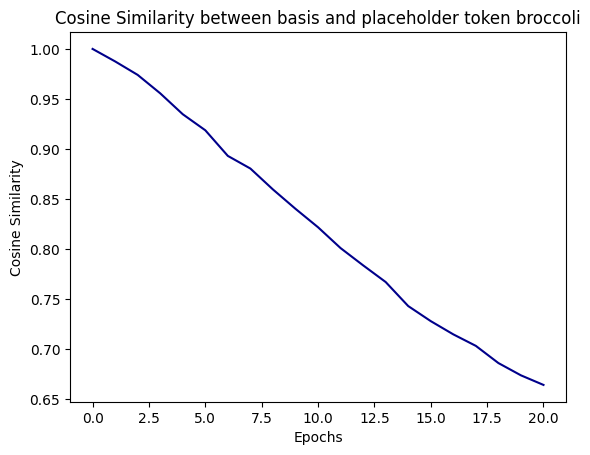

<Figure size 640x480 with 0 Axes>

In [13]:
### extract x and y values from the data
x_values = epoch_numb
y_values = cosine_broc

### plot data using Matplotlib
plot(x_values = x_values, y_values = y_values, color='darkblue', xlabel = 'Epochs', ylabel = 'Cosine Similarity', title = 'Cosine Similarity between basis and placeholder token broccoli')

### save the plot as a file
plt.savefig('/content/drive/MyDrive/CosineBrocc.jpg')

### if you want to save the figure in another format, you can also choose one of those below
### plt.savefig('/content/drive/MyDrive/EPS/CosineBrocc.eps', format='eps')
### plt.savefig('/content/drive/MyDrive/EPS/CosineBrocc.pdf', format='pdf')

<Figure size 640x480 with 0 Axes>

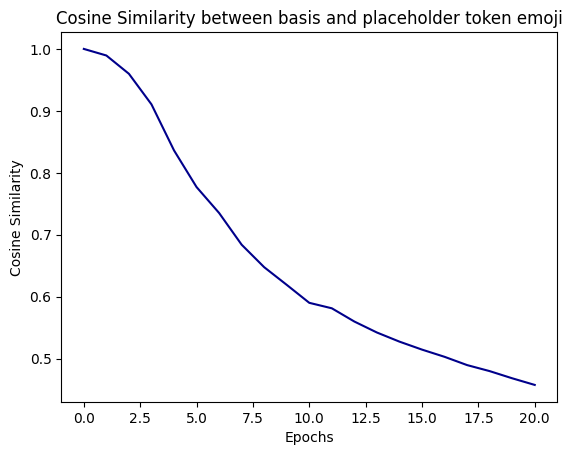

<Figure size 640x480 with 0 Axes>

In [22]:
### extract x and y values from the data
x_values = epoch_numb
y_values = cosine_emoji

### plot data using Matplotlib
plot(x_values = x_values, y_values = y_values, color='darkblue', xlabel = 'Epochs', ylabel = 'Cosine Similarity', title = 'Cosine Similarity between basis and placeholder token emoji')

### save the plot as a file
plt.savefig('/content/drive/MyDrive/CosineEmoji.jpg', format = 'jpg')

### if you want to save the figure in another format, you can also choose one of those below
### plt.savefig('/content/drive/MyDrive/EPS/CosineBrocc.eps', format='eps')
### plt.savefig('/content/drive/MyDrive/EPS/CosineBrocc.pdf', format='pdf')